Baixando e extraindo o dataset:

Importando as bibliotecas necessárias.

In [7]:
!pip install tensorflow_addons
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.7.0


In [8]:
from google.colab import drive
drive._mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 100

diretorio = 'dataset_aumentado'

TRAIN_PATH = os.path.join(diretorio, 'train')
TEST_PATH = os.path.join(diretorio, 'test')
VALIDATION_PATH = os.path.join(diretorio, 'validation')

classes={
    0:'CD',
    1:'MF',
    2:'MP',
    3:'MR',
    4:'MG',
    5:'MT',
    6:'RG',
    7:'TA',
    8:'TB',
    9:'TR',
    10:'TC',
    11:'TN'
}

In [10]:
!pip install --quiet vit-keras

from vit_keras import vit

In [11]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=vit.preprocess_inputs)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=vit.preprocess_inputs)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=vit.preprocess_inputs)

train_set = train_datagen.flow_from_directory(TRAIN_PATH,
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                              class_mode='categorical',
                                              batch_size=BATCH_SIZE)

val_set = train_datagen.flow_from_directory(VALIDATION_PATH,
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                              class_mode='categorical',
                                              batch_size=BATCH_SIZE)

test_set = test_datagen.flow_from_directory(TEST_PATH, 
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            class_mode='categorical',
                                            batch_size=1,
                                            shuffle=False)

Found 6718 images belonging to 12 classes.
Found 132 images belonging to 12 classes.
Found 72 images belonging to 12 classes.


In [12]:
vit_model = vit.vit_b16(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = len(classes))

347512832/347502902 [==============================] - 4s 0us/step


In [13]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalMaxPooling2D

x = tf.keras.layers.Flatten()(vit_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(len(classes), activation='softmax')(x)
model = tf.keras.models.Model(vit_model.input, output) 


for layer in range(len(vit_model.layers)):
    vit_model.layers[layer].treinable=False

In [14]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])


STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = val_set.n // val_set.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 3,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/gdrive/MyDrive/model3.h5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

model.fit(x = train_set,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = val_set,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

#model.save('model.h5', save_weights_only = True)

model.load_weights('/content/gdrive/MyDrive/model3.h5')

learning_rate = 1e-6

for layer in range(len(vit_model.layers)):
    vit_model.layers[layer].treinable=True
  

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])


model.fit(x = train_set,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = val_set,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

model.load_weights('/content/gdrive/MyDrive/model3.h5')


Epoch 1/100
209/209 [==============================] - ETA: 0s - loss: 2.1491 - accuracy: 0.3570
Epoch 00001: val_accuracy improved from -inf to 0.74219, saving model to /content/gdrive/MyDrive/model3.h5
209/209 [==============================] - 583s 3s/step - loss: 2.1491 - accuracy: 0.3570 - val_loss: 1.4606 - val_accuracy: 0.7422 - lr: 1.0000e-04
Epoch 2/100
209/209 [==============================] - ETA: 0s - loss: 1.2435 - accuracy: 0.8911
Epoch 00002: val_accuracy improved from 0.74219 to 0.89062, saving model to /content/gdrive/MyDrive/model3.h5
209/209 [==============================] - 539s 3s/step - loss: 1.2435 - accuracy: 0.8911 - val_loss: 1.1777 - val_accuracy: 0.8906 - lr: 1.0000e-04
Epoch 3/100
209/209 [==============================] - ETA: 0s - loss: 1.0544 - accuracy: 0.9825
Epoch 00003: val_accuracy improved from 0.89062 to 0.89844, saving model to /content/gdrive/MyDrive/model3.h5
209/209 [==============================] - 539s 3s/step - loss: 1.0544 - accuracy: 0

['Codega', 'Malvasia Fina', 'Malvasia Preta', 'Malvasia Rei', 'Moscatel Galego', 'Mourisco Tinto', 'Rabigato', 'Tinta Amarela', 'Tinta Barroca', 'Tinta Roriz', 'Tinto Cao', 'Touriga Nacional']
              precision    recall  f1-score   support

          CD       1.00      0.50      0.67         6
          MF       0.86      1.00      0.92         6
          MP       1.00      1.00      1.00         6
          MR       0.67      1.00      0.80         6
          MG       1.00      1.00      1.00         6
          MT       0.86      1.00      0.92         6
          RG       1.00      0.50      0.67         6
          TA       0.75      1.00      0.86         6
          TB       1.00      0.83      0.91         6
          TR       1.00      1.00      1.00         6
          TC       0.86      1.00      0.92         6
          TN       1.00      0.83      0.91         6

    accuracy                           0.89        72
   macro avg       0.92      0.89      0.88      

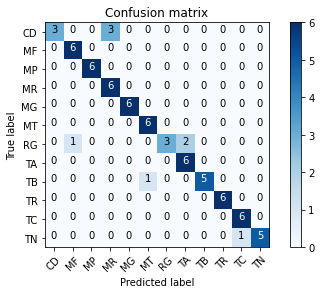

In [15]:
classes={
    'Codega':'CD',
    'Malvasia Fina':'MF',
    'Malvasia Preta':'MP',
    'Malvasia Rei':'MR',
    'Moscatel Galego':'MG',
    'Mourisco Tinto':'MT',
    'Rabigato':'RG',
    'Tinta Amarela':'TA',
    'Tinta Barroca':'TB',
    'Tinta Roriz':'TR',
    'Tinto Cao':'TC',
    'Touriga Nacional':'TN'
}

from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def confusion_matrix(test_data_generator, model):
  test_data_generator.reset()
  predictions = model.predict(test_data_generator, steps=test_set.samples)
  # Get most likely class
  predicted_classes = np.argmax(predictions, axis=1)
  true_classes = test_data_generator.classes
  class_labels = list(test_data_generator.class_indices.keys())
  print(class_labels)
  class_labels = [classes[x] for x in class_labels]  

  report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
  cm = metrics.confusion_matrix(true_classes, predicted_classes)
  print(report)
  plot_confusion_matrix(cm, class_labels)


confusion_matrix(test_set, model)